### Import the relevant libraries

In [7]:
# We must always import the relevant libraries for our problem at hand. NumPy and TensorFlow are required for this example.
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


### Data generation

We generate data using the exact same logic and code as the example from the previous notebook. The only difference now is that we save it to an npz file. Npz is numpy's file type which allows you to save numpy arrays into a single .npz file. We introduce this change because in machine learning most often: 

* you are given some data (csv, database, etc.)
* you preprocess it into a desired format (later on we will see methods for preprocesing)
* you save it into npz files (if you're working in Python) to access later

Nothing to worry about - this is literally saving your NumPy arrays into a file that you can later access, nothing more.

In [2]:
# First, we should declare a variable containing the size of the training set we want to generate.
observations = 1000

# We will work with two variables as inputs. You can think about them as x1 and x2 in our previous examples.
# We have picked x and z, since it is easier to differentiate them.
# We generate them randomly, drawing from an uniform distribution. There are 3 arguments of this method (low, high, size).
# The size of xs and zs is observations x 1. In this case: 1000 x 1.
xs = np.random.uniform(low=-10, high=10, size=(observations,1))
zs = np.random.uniform(-10, 10, (observations,1))

# Combine the two dimensions of the input into one input matrix. 
# This is the X matrix from the linear model y = x*w + b.
# column_stack is a Numpy method, which combines two matrices (vectors) into one.
generated_inputs = np.column_stack((xs,zs))

# We add a random small noise to the function i.e. f(x,z) = 2x - 3z + 5 + <small noise>
noise = np.random.uniform(-1, 1, (observations,1))

# Produce the targets according to our f(x,z) = 2x - 3z + 5 + noise definition.
# In this way, we are basically saying: the weights should be 2 and -3, while the bias is 5.
generated_targets = 2*xs - 3*zs + 5 + noise

# save into an npz file called "TF_intro"
np.savez('TF_intro', inputs=generated_inputs, targets=generated_targets)

In [5]:
xs.size

1000

In [6]:
zs

array([[-7.60108422e+00],
       [-1.49886055e+00],
       [ 6.45282175e-01],
       [-1.58483048e-01],
       [ 4.05122329e+00],
       [-4.81290997e+00],
       [-5.96534799e+00],
       [-4.90382175e-01],
       [ 1.39347107e+00],
       [ 8.94105865e+00],
       [-2.26884565e+00],
       [-5.27396246e+00],
       [ 1.87068410e+00],
       [-8.33264449e+00],
       [ 2.18462888e+00],
       [-9.77561757e+00],
       [-7.79923737e+00],
       [ 1.77087406e+00],
       [ 4.59223898e+00],
       [-7.16887109e+00],
       [-5.99615164e+00],
       [-9.53251200e+00],
       [ 6.09883641e+00],
       [-2.96318034e+00],
       [-9.42070347e+00],
       [-7.16145854e+00],
       [-9.66178257e+00],
       [ 6.43782309e+00],
       [ 4.22587714e+00],
       [-3.56170332e+00],
       [ 1.85112634e+00],
       [ 3.31880571e+00],
       [-3.66740504e+00],
       [ 6.17476510e+00],
       [-4.05545377e-01],
       [-3.82214836e+00],
       [ 1.22604457e+00],
       [-5.00346984e+00],
       [-9.3

## Solving with TensorFlow

<i/>Note: This intro is just the basics of TensorFlow which has way more capabilities and depth than that.<i>

In [3]:
# The shape of the data we've prepared above. Think about it as: number of inputs, number of outputs.
input_size = 2
output_size = 1

### Outlining the model

In [8]:
# Here we define a basic TensorFlow object - the placeholder.
# As before, we will feed the inputs and targets to the model. 
# In the TensorFlow context, we feed the data to the model THROUGH the placeholders. 
# The particular inputs and targets are contained in our .npz file.

# The first None parameter of the placeholders' shape means that
# this dimension could be of any length. That's since we are mainly interested in
# the input size, i.e. how many input variables we have and not the number of samples (observations)
# The number of input variables changes the MODEL itself, while the number of observations doesn't.
# Remember that the weights and biases were independent of the number of samples, so the MODEL is independent.
# Important: NO calculation happens at this point.
inputs = tf.placeholder(tf.float32, [None, input_size])
targets = tf.placeholder(tf.float32, [None, output_size])

# As before, we define our weights and biases.
# They are the other basic TensorFlow object - a variable.
# We feed data into placeholders and they have a different value for each iteration
# Variables, however, preserve their values across iterations.
# To sum up, data goes into placeholders; parameters go into variables.

# We use the same random uniform initialization in [-0.1,0.1] as in the minimal example but using the TF syntax
# Important: NO calculation happens at this point.
weights = tf.Variable(tf.random_uniform([input_size, output_size], minval=-0.1, maxval=0.1))
biases = tf.Variable(tf.random_uniform([output_size], minval=-0.1, maxval=0.1))

# We get the outputs following our linear combination: y = xw + b
# Important: NO calculation happens at this point.
# This line simply tells TensorFlow what rule to apply when we feed in the training data (below).
outputs = tf.matmul(inputs, weights) + biases

In [12]:
inputs

<tf.Tensor 'Placeholder:0' shape=(?, 2) dtype=float32>

In [9]:
weights

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32_ref>

In [11]:
outputs

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

### Choosing the objective function and the optimization method

In [13]:
# Again, we use a loss function, this time readily available, though.
# mean_squared_error is the scaled L2-norm (per observation)
# We divide by two to follow our earlier definitions. That doesn't really change anything.
mean_loss = tf.losses.mean_squared_error(labels=targets, predictions=outputs) / 2.

# Note that there also exists a function tf.nn.l2_loss. 
# tf.nn.l2_loss calculates the loss over all samples, instead of the average loss per sample.
# Practically it's the same, a matter of preference.
# The difference would be a smaller or larger learning rate to achieve the exact same result.

# Instead of implementing Gradient Descent on our own, in TensorFlow we can simply state
# "Minimize the mean loss by using Gradient Descent with a given learning rate"
# Simple as that.
optimize = tf.train.GradientDescentOptimizer(learning_rate=0.05).minimize(mean_loss)

### Prepare for execution

In [14]:
# So far we've defined the placeholders, variables, the loss function and the optimization method.
# We have the structure for training, but we haven't trained anything yet.
# The actual training (and subsequent implementation of the ML algorithm) happens inside sessions.
sess = tf.InteractiveSession()

### Initializing variables

In [15]:
# Before we start training, we need to initialize our variables: the weights and biases.
# There is a specific method for initializing called global_variables_initializer().
# Let's declare a variable "initializer" that will do that.
initializer = tf.global_variables_initializer()

# Time to initialize the variables.
sess.run(initializer)

### Loading training data

In [16]:
# We finally load the training data we created above.
training_data = np.load('TF_intro.npz')

In [21]:
training_data

### Learning

In [17]:
# As in the previous example, we train for a set number (100) of iterations over the dataset
for i in range(100):
    # This expression is a bit more complex but you'll learn to appreciate its power and
    # flexibility in the following lessons.
    # sess.run is the session's function to actually do something, anything.
    # Above, we used it to initialize the variables.
    # Here, we use it to feed the training data to the computational graph, defined by the feed_dict parameter
    # and run operations (already defined above), given as the first parameter (optimize, mean_loss).
    
    # So the line of code means: "Run the optimize and mean_loss operations by filling the placeholder
    # objects with data from the feed_dict parameter".
    # Curr_loss catches the output from the two operations.
    # Using "_," we omit the first one, because optimize has no output (it's always "None"). 
    # The second one catches the value of the mean_loss for the current run, thus curr_loss actually = mean_loss 
    _, curr_loss = sess.run([optimize, mean_loss], 
        feed_dict={inputs: training_data['inputs'], targets: training_data['targets']})
                                            # targets will go into mean_loss 
    
    # We print the current average loss
    print(curr_loss)

241.57835
134.70845
78.96422
48.26497
30.755924
20.513882
14.3837595
10.619453
8.233637
6.6611533
5.5759826
4.788863
4.189168
3.7116632
3.317379
2.9826207
2.6926064
2.437808
2.211815
2.0101085
1.8293359
1.6668947
1.5206733
1.3889079
1.2700843
1.1628844
1.0661421
0.97882164
0.8999954
0.8288324
0.76458424
0.70657706
0.65420413
0.60691684
0.5642215
0.52567226
0.49086592
0.4594387
0.43106335
0.40544298
0.38231003
0.36142325
0.34256485
0.32553688
0.31016225
0.29628044
0.2837469
0.27242985
0.26221156
0.25298545
0.24465518
0.23713383
0.23034252
0.22421066
0.21867421
0.21367535
0.20916176
0.20508648
0.20140682
0.19808444
0.19508466
0.19237617
0.18993059
0.1877225
0.18572874
0.18392861
0.18230323
0.18083572
0.17951064
0.17831427
0.17723396
0.17625864
0.17537802
0.17458282
0.17386496
0.1732167
0.17263143
0.17210294
0.17162576
0.17119496
0.17080595
0.17045471
0.17013757
0.16985126
0.16959272
0.16935928
0.16914853
0.16895819
0.16878636
0.16863123
0.16849113
0.16836467
0.16825046
0.16814736
0.16805

### Plotting the data

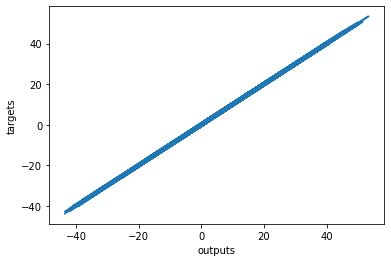

In [18]:
# As before, we want to plot the last output vs targets after the training is supposedly over.
# Same notation as above but this time we don't want to train anymore, and we are not interested
# in the loss function value.
# What we want, however, are the outputs. 
# Therefore, instead of the optimize and mean_loss operations, we pass the "outputs" as the only parameter.
out = sess.run([outputs], 
               feed_dict={inputs: training_data['inputs']})
# The model is optimized, so the outputs are calculated based on the last form of the model

# We have to np.squeeze the arrays in order to fit them to what the plot function expects.
# Doesn't change anything as we cut dimensions of size 1 - just a technicality.
plt.plot(np.squeeze(out), np.squeeze(training_data['targets']))
plt.xlabel('outputs')
plt.ylabel('targets')
plt.show()
        
# Voila - what you see should be exactly the same as in the previous notebook!
# You probably don't see the point of TensorFlow now - it took us more lines of code
# to achieve this simple result. However, once we go deeper in the next chapter,
# TensorFlow will save us hundreds of lines of code.